In [1]:
import pandas as pd #pdเป็นการย่อจากpandas
import nltk
import string # ใช้สำหรับดึงรายการสัญลักษณ์พิเศษ
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer #โมเดลTF-IDF
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt #matplotlib คือ libraryหนึ่งเอาไว้พรอตกราฟ
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import openai
import os
import time
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer #เป็นการนำเข้าobject สำหรับทำLemmatiz
from collections import Counter
from sentence_transformers import SentenceTransformer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # Open Multilingual Wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# จัดเตรียมข้อมูล

ตัดคอลัมน์ต่าง ๆ ออก ให้เหลือเพียงคอลัมน์ title และ desciption เพราะ
คอลัมน์ title เป็นคอลัมน์หลักที่ใช้ในการแบ่งประเภท มักจะสรุปใจความหลักและมีkeyword ที่บ่งบอกเนื้อหาของข่าวได้อย่างชัดเจน
คอลัมน์ desciption เป็นคอลัมน์ที่สำคัญรองลงมาจากคอลัมน์ title เนื่องจากมีรายละเอียดและบริบทเพิ่มเติม ช่วยให้การแบ่งประเภทมีความแม่นยำสูงขึ้น โดยบางครั้งหัวข้อข่าวอย่างเดียวอาจกำกวม แต่คำอธิบายจะช่วยยืนยันประเภทของข่าวได้ดียิ่งขึ้น จึงเหมาะที่จะนำมาวิเคาระห์ร่วมกับคอลัมน์ title

In [2]:
filename = 'bbc_news.csv'
df = pd.read_csv(filename) 
df_new = df.drop(columns=['pubDate','guid','link'])

print("DataFrame ใหม่ที่ไม่มีคอลัมน์ 'pubDate','guid','link':")
df_new

DataFrame ใหม่ที่ไม่มีคอลัมน์ 'pubDate','guid','link':


,title,description
0,Ukraine: Angry Zelensky vows to punish Russian...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,Consumers are feeling the impact of higher ene...
...,...,...
42110,Highlights: Wales make history in Dublin,Watch highlights as Wales win 2-1 in Dublin fo...
42111,Gang jailed over £200m of cocaine in banana boxes,More than two tonnes of the Class A drug was s...
42112,Scottish Budget presents huge challenges for SNP,Finance Secretary Shona Robison is preparing t...
42113,Celebrations as Wales make history qualifying ...,Wales defeated the Republic of Ireland 2-1 mak...


# data cleansing

## ทำให้เป็นตัวพิมพ์เล็ก

เนื่องจากในทางคอมพิวเตอร์ ตัวอักษรพิมพ์เล็กกับตัวอักษรพิมพ์ใหญ่เป็นคนละตัวกัน เช่น EAT , Eat , eat คอมพิวเตอร์จะมองว่าเป็นสามคำที่แตกต่างกัน ทั้ง ๆ ที่มีความหมายเหมือนกัน จึงต้องแปลงให้เป็นตัวอักษรพิมพ์เล็กทั้งหมด เพื่อเป็นการบังคับให้คำเดียวกันมีรูปแบบเดียวกัน

In [3]:
df_new[['title', 'description']] = df_new[['title', 'description']].apply(lambda x: x.str.lower())
(df_new)

,title,description
0,ukraine: angry zelensky vows to punish russian...,the ukrainian president says the country will ...
1,war in ukraine: taking cover in a town under a...,"jeremy bowen was on the frontline in irpin, as..."
2,ukraine war 'catastrophic for global food',one of the world's biggest fertiliser firms sa...
3,manchester arena bombing: saffie roussos's par...,the parents of the manchester arena bombing's ...
4,ukraine conflict: oil price soars to highest l...,consumers are feeling the impact of higher ene...
...,...,...
42110,highlights: wales make history in dublin,watch highlights as wales win 2-1 in dublin fo...
42111,gang jailed over £200m of cocaine in banana boxes,more than two tonnes of the class a drug was s...
42112,scottish budget presents huge challenges for snp,finance secretary shona robison is preparing t...
42113,celebrations as wales make history qualifying ...,wales defeated the republic of ireland 2-1 mak...


# ทำ tokenization

แบ่งข้อความนั้นออกเป็นหน่วยที่มีความหมาย (เช่น คำ) เพื่อให้คอมพิวเตอร์สามารถนำไปประมวลผลต่อในเชิงโครงสร้างได้ คือ การเปลี่ยน "ข้อความ" ที่ไม่มีโครงสร้าง ให้กลายเป็น "ข้อมูล" ที่มีโครงสร้างและจัดการได้

In [4]:
df_new['title_tokenized'] = df_new['title'].str.split()
df_new['description_tokenized'] = df_new['description'].str.split()
df_new[['title_tokenized', 'description_tokenized']] = df_new[['title', 'description']].apply(lambda x: x.str.split())
df_new

,title,description,title_tokenized,description_tokenized
0,ukraine: angry zelensky vows to punish russian...,the ukrainian president says the country will ...,"[ukraine:, angry, zelensky, vows, to, punish, ...","[the, ukrainian, president, says, the, country..."
1,war in ukraine: taking cover in a town under a...,"jeremy bowen was on the frontline in irpin, as...","[war, in, ukraine:, taking, cover, in, a, town...","[jeremy, bowen, was, on, the, frontline, in, i..."
2,ukraine war 'catastrophic for global food',one of the world's biggest fertiliser firms sa...,"[ukraine, war, 'catastrophic, for, global, food']","[one, of, the, world's, biggest, fertiliser, f..."
3,manchester arena bombing: saffie roussos's par...,the parents of the manchester arena bombing's ...,"[manchester, arena, bombing:, saffie, roussos'...","[the, parents, of, the, manchester, arena, bom..."
4,ukraine conflict: oil price soars to highest l...,consumers are feeling the impact of higher ene...,"[ukraine, conflict:, oil, price, soars, to, hi...","[consumers, are, feeling, the, impact, of, hig..."
...,...,...,...,...
42110,highlights: wales make history in dublin,watch highlights as wales win 2-1 in dublin fo...,"[highlights:, wales, make, history, in, dublin]","[watch, highlights, as, wales, win, 2-1, in, d..."
42111,gang jailed over £200m of cocaine in banana boxes,more than two tonnes of the class a drug was s...,"[gang, jailed, over, £200m, of, cocaine, in, b...","[more, than, two, tonnes, of, the, class, a, d..."
42112,scottish budget presents huge challenges for snp,finance secretary shona robison is preparing t...,"[scottish, budget, presents, huge, challenges,...","[finance, secretary, shona, robison, is, prepa..."
42113,celebrations as wales make history qualifying ...,wales defeated the republic of ireland 2-1 mak...,"[celebrations, as, wales, make, history, quali...","[wales, defeated, the, republic, of, ireland, ..."


# ทำ stopword

เพื่อลดขนาดข้อมูลและเพิ่มประสิทธิภาพการประมวลผล ช่วยให้โมเดลจับสาระสำคัญของข้อความได้ดีขึ้น นอกจากนี้ยังช่วยให้การจำแนกประเภทของข้อความหรือการจัดกลุ่มของข้อความเป็นไปได้ง่ายยิ่งขึ้น

In [5]:
stop_words = set(stopwords.words('english')) # ใช้ set() เพื่อให้การค้นหาเร็วกว่า list
def remove_stopwords(tokens):
  return [word for word in tokens if word not in stop_words]
columns_to_process = ['title_tokenized', 'description_tokenized']
for col in columns_to_process:
  new_col_name = col.replace('_tokenized', '_cleaned')
  df_new[new_col_name] = df_new[col].apply(remove_stopwords)
df_new

,title,description,title_tokenized,description_tokenized,title_cleaned,description_cleaned
0,ukraine: angry zelensky vows to punish russian...,the ukrainian president says the country will ...,"[ukraine:, angry, zelensky, vows, to, punish, ...","[the, ukrainian, president, says, the, country...","[ukraine:, angry, zelensky, vows, punish, russ...","[ukrainian, president, says, country, forgive,..."
1,war in ukraine: taking cover in a town under a...,"jeremy bowen was on the frontline in irpin, as...","[war, in, ukraine:, taking, cover, in, a, town...","[jeremy, bowen, was, on, the, frontline, in, i...","[war, ukraine:, taking, cover, town, attack]","[jeremy, bowen, frontline, irpin,, residents, ..."
2,ukraine war 'catastrophic for global food',one of the world's biggest fertiliser firms sa...,"[ukraine, war, 'catastrophic, for, global, food']","[one, of, the, world's, biggest, fertiliser, f...","[ukraine, war, 'catastrophic, global, food']","[one, world's, biggest, fertiliser, firms, say..."
3,manchester arena bombing: saffie roussos's par...,the parents of the manchester arena bombing's ...,"[manchester, arena, bombing:, saffie, roussos'...","[the, parents, of, the, manchester, arena, bom...","[manchester, arena, bombing:, saffie, roussos'...","[parents, manchester, arena, bombing's, younge..."
4,ukraine conflict: oil price soars to highest l...,consumers are feeling the impact of higher ene...,"[ukraine, conflict:, oil, price, soars, to, hi...","[consumers, are, feeling, the, impact, of, hig...","[ukraine, conflict:, oil, price, soars, highes...","[consumers, feeling, impact, higher, energy, c..."
...,...,...,...,...,...,...
42110,highlights: wales make history in dublin,watch highlights as wales win 2-1 in dublin fo...,"[highlights:, wales, make, history, in, dublin]","[watch, highlights, as, wales, win, 2-1, in, d...","[highlights:, wales, make, history, dublin]","[watch, highlights, wales, win, 2-1, dublin, 3..."
42111,gang jailed over £200m of cocaine in banana boxes,more than two tonnes of the class a drug was s...,"[gang, jailed, over, £200m, of, cocaine, in, b...","[more, than, two, tonnes, of, the, class, a, d...","[gang, jailed, £200m, cocaine, banana, boxes]","[two, tonnes, class, drug, seized, shipment, c..."
42112,scottish budget presents huge challenges for snp,finance secretary shona robison is preparing t...,"[scottish, budget, presents, huge, challenges,...","[finance, secretary, shona, robison, is, prepa...","[scottish, budget, presents, huge, challenges,...","[finance, secretary, shona, robison, preparing..."
42113,celebrations as wales make history qualifying ...,wales defeated the republic of ireland 2-1 mak...,"[celebrations, as, wales, make, history, quali...","[wales, defeated, the, republic, of, ireland, ...","[celebrations, wales, make, history, qualifyin...","[wales, defeated, republic, ireland, 2-1, maki..."


# ทำ Lemmatization

คือกระบวนการ แปลงรูปของคำศัพท์ต่างๆ ให้กลับไปอยู่ในรูปพื้นฐาน (Base Form) เพื่อง่ายต่อการจัดประเภท

In [6]:
lemmatizer = WordNetLemmatizer()
columns_to_process = ['title_cleaned', 'description_cleaned']
def lemmatize_tokens(token_list):
    return [lemmatizer.lemmatize(word) for word in token_list]
for col in columns_to_process:
    new_col_name = col.replace('_cleaned', '_lemmatized')
    df_new[new_col_name] = df_new[col].apply(lemmatize_tokens)
df_new

,title,description,title_tokenized,description_tokenized,title_cleaned,description_cleaned,title_lemmatized,description_lemmatized
0,ukraine: angry zelensky vows to punish russian...,the ukrainian president says the country will ...,"[ukraine:, angry, zelensky, vows, to, punish, ...","[the, ukrainian, president, says, the, country...","[ukraine:, angry, zelensky, vows, punish, russ...","[ukrainian, president, says, country, forgive,...","[ukraine:, angry, zelensky, vow, punish, russi...","[ukrainian, president, say, country, forgive, ..."
1,war in ukraine: taking cover in a town under a...,"jeremy bowen was on the frontline in irpin, as...","[war, in, ukraine:, taking, cover, in, a, town...","[jeremy, bowen, was, on, the, frontline, in, i...","[war, ukraine:, taking, cover, town, attack]","[jeremy, bowen, frontline, irpin,, residents, ...","[war, ukraine:, taking, cover, town, attack]","[jeremy, bowen, frontline, irpin,, resident, c..."
2,ukraine war 'catastrophic for global food',one of the world's biggest fertiliser firms sa...,"[ukraine, war, 'catastrophic, for, global, food']","[one, of, the, world's, biggest, fertiliser, f...","[ukraine, war, 'catastrophic, global, food']","[one, world's, biggest, fertiliser, firms, say...","[ukraine, war, 'catastrophic, global, food']","[one, world's, biggest, fertiliser, firm, say,..."
3,manchester arena bombing: saffie roussos's par...,the parents of the manchester arena bombing's ...,"[manchester, arena, bombing:, saffie, roussos'...","[the, parents, of, the, manchester, arena, bom...","[manchester, arena, bombing:, saffie, roussos'...","[parents, manchester, arena, bombing's, younge...","[manchester, arena, bombing:, saffie, roussos'...","[parent, manchester, arena, bombing's, younges..."
4,ukraine conflict: oil price soars to highest l...,consumers are feeling the impact of higher ene...,"[ukraine, conflict:, oil, price, soars, to, hi...","[consumers, are, feeling, the, impact, of, hig...","[ukraine, conflict:, oil, price, soars, highes...","[consumers, feeling, impact, higher, energy, c...","[ukraine, conflict:, oil, price, soar, highest...","[consumer, feeling, impact, higher, energy, co..."
...,...,...,...,...,...,...,...,...
42110,highlights: wales make history in dublin,watch highlights as wales win 2-1 in dublin fo...,"[highlights:, wales, make, history, in, dublin]","[watch, highlights, as, wales, win, 2-1, in, d...","[highlights:, wales, make, history, dublin]","[watch, highlights, wales, win, 2-1, dublin, 3...","[highlights:, wale, make, history, dublin]","[watch, highlight, wale, win, 2-1, dublin, 3-2..."
42111,gang jailed over £200m of cocaine in banana boxes,more than two tonnes of the class a drug was s...,"[gang, jailed, over, £200m, of, cocaine, in, b...","[more, than, two, tonnes, of, the, class, a, d...","[gang, jailed, £200m, cocaine, banana, boxes]","[two, tonnes, class, drug, seized, shipment, c...","[gang, jailed, £200m, cocaine, banana, box]","[two, tonne, class, drug, seized, shipment, co..."
42112,scottish budget presents huge challenges for snp,finance secretary shona robison is preparing t...,"[scottish, budget, presents, huge, challenges,...","[finance, secretary, shona, robison, is, prepa...","[scottish, budget, presents, huge, challenges,...","[finance, secretary, shona, robison, preparing...","[scottish, budget, present, huge, challenge, snp]","[finance, secretary, shona, robison, preparing..."
42113,celebrations as wales make history qualifying ...,wales defeated the republic of ireland 2-1 mak...,"[celebrations, as, wales, make, history, quali...","[wales, defeated, the, republic, of, ireland, ...","[celebrations, wales, make, history, qualifyin...","[wales, defeated, republic, ireland, 2-1, maki...","[celebration, wale, make, history, qualifying,...","[wale, defeated, republic, ireland, 2-1, makin..."


# รวมคอลัมน์ title และ description เข้าด้วยกัน

In [7]:
df_new['text'] = df_new['title_lemmatized'] + df_new['description_lemmatized']
df_new

,title,description,title_tokenized,description_tokenized,title_cleaned,description_cleaned,title_lemmatized,description_lemmatized,text
0,ukraine: angry zelensky vows to punish russian...,the ukrainian president says the country will ...,"[ukraine:, angry, zelensky, vows, to, punish, ...","[the, ukrainian, president, says, the, country...","[ukraine:, angry, zelensky, vows, punish, russ...","[ukrainian, president, says, country, forgive,...","[ukraine:, angry, zelensky, vow, punish, russi...","[ukrainian, president, say, country, forgive, ...","[ukraine:, angry, zelensky, vow, punish, russi..."
1,war in ukraine: taking cover in a town under a...,"jeremy bowen was on the frontline in irpin, as...","[war, in, ukraine:, taking, cover, in, a, town...","[jeremy, bowen, was, on, the, frontline, in, i...","[war, ukraine:, taking, cover, town, attack]","[jeremy, bowen, frontline, irpin,, residents, ...","[war, ukraine:, taking, cover, town, attack]","[jeremy, bowen, frontline, irpin,, resident, c...","[war, ukraine:, taking, cover, town, attack, j..."
2,ukraine war 'catastrophic for global food',one of the world's biggest fertiliser firms sa...,"[ukraine, war, 'catastrophic, for, global, food']","[one, of, the, world's, biggest, fertiliser, f...","[ukraine, war, 'catastrophic, global, food']","[one, world's, biggest, fertiliser, firms, say...","[ukraine, war, 'catastrophic, global, food']","[one, world's, biggest, fertiliser, firm, say,...","[ukraine, war, 'catastrophic, global, food', o..."
3,manchester arena bombing: saffie roussos's par...,the parents of the manchester arena bombing's ...,"[manchester, arena, bombing:, saffie, roussos'...","[the, parents, of, the, manchester, arena, bom...","[manchester, arena, bombing:, saffie, roussos'...","[parents, manchester, arena, bombing's, younge...","[manchester, arena, bombing:, saffie, roussos'...","[parent, manchester, arena, bombing's, younges...","[manchester, arena, bombing:, saffie, roussos'..."
4,ukraine conflict: oil price soars to highest l...,consumers are feeling the impact of higher ene...,"[ukraine, conflict:, oil, price, soars, to, hi...","[consumers, are, feeling, the, impact, of, hig...","[ukraine, conflict:, oil, price, soars, highes...","[consumers, feeling, impact, higher, energy, c...","[ukraine, conflict:, oil, price, soar, highest...","[consumer, feeling, impact, higher, energy, co...","[ukraine, conflict:, oil, price, soar, highest..."
...,...,...,...,...,...,...,...,...,...
42110,highlights: wales make history in dublin,watch highlights as wales win 2-1 in dublin fo...,"[highlights:, wales, make, history, in, dublin]","[watch, highlights, as, wales, win, 2-1, in, d...","[highlights:, wales, make, history, dublin]","[watch, highlights, wales, win, 2-1, dublin, 3...","[highlights:, wale, make, history, dublin]","[watch, highlight, wale, win, 2-1, dublin, 3-2...","[highlights:, wale, make, history, dublin, wat..."
42111,gang jailed over £200m of cocaine in banana boxes,more than two tonnes of the class a drug was s...,"[gang, jailed, over, £200m, of, cocaine, in, b...","[more, than, two, tonnes, of, the, class, a, d...","[gang, jailed, £200m, cocaine, banana, boxes]","[two, tonnes, class, drug, seized, shipment, c...","[gang, jailed, £200m, cocaine, banana, box]","[two, tonne, class, drug, seized, shipment, co...","[gang, jailed, £200m, cocaine, banana, box, tw..."
42112,scottish budget presents huge challenges for snp,finance secretary shona robison is preparing t...,"[scottish, budget, presents, huge, challenges,...","[finance, secretary, shona, robison, is, prepa...","[scottish, budget, presents, huge, challenges,...","[finance, secretary, shona, robison, preparing...","[scottish, budget, present, huge, challenge, snp]","[finance, secretary, shona, robison, preparing...","[scottish, budget, present, huge, challenge, s..."
42113,celebrations as wales make history qualifying ...,wales defeated the republic of ireland 2-1 mak...,"[celebrations, as, wales, make, histo

# ทำเป็น vector embedding

เพื่อแปลง "ความหมาย" ของคำศัพท์และประโยค ให้อยู่ในรูปของ "ตัวเลข" ที่คอมพิวเตอร์สามารถเข้าใจและนำไปคำนวณต่อได้

In [8]:
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

sentences_to_embed = df_new['text'].tolist()

embeddings = model.encode(sentences_to_embed, show_progress_bar=True)

df_new['text_vector'] = list(embeddings)
df_new

Batches:   0%|          | 0/1317 [00:00<?, ?it/s]

# หาค่า K ที่เหมาะสม

In [32]:
k_range = range(2, 11)
X = np.array(df_new['text_vector'].tolist())
# --- วิธีที่ 2.1: Elbow Method ---
inertia_values = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_) # inertia คือค่า Sum of Squared Errors (SSE)

# --- วิธีที่ 2.2: Silhouette Score ---
silhouette_values = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_values.append(score)

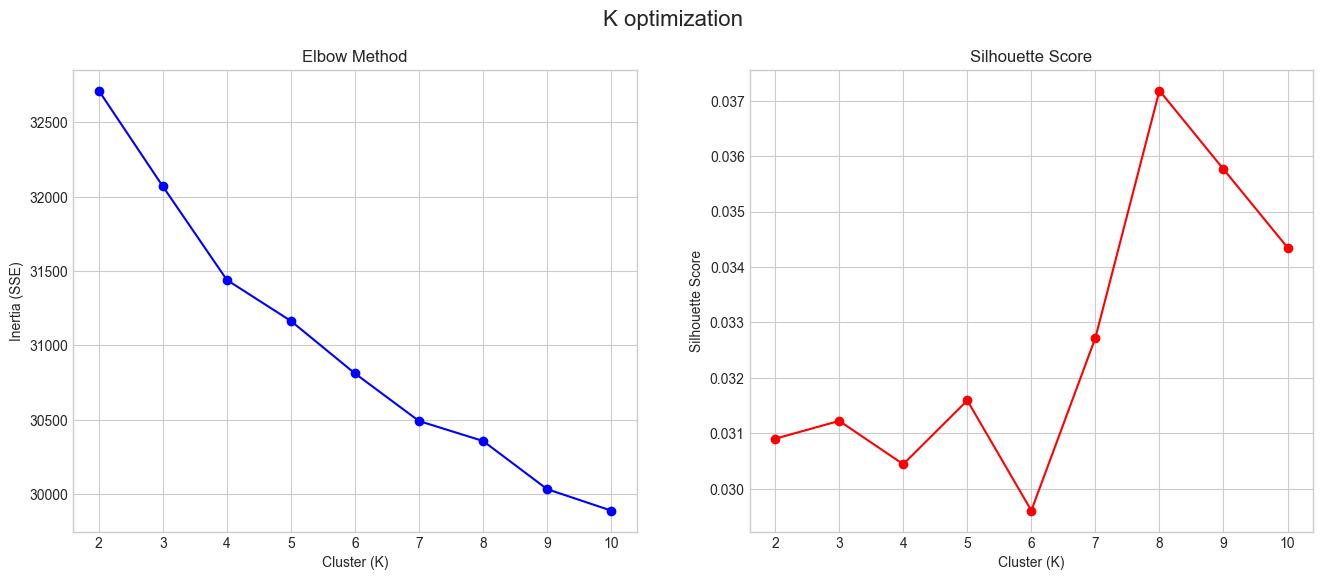

ค่า K ที่ให้ Silhouette Score สูงสุดคือ: 8


In [19]:
# --- พล็อตกราฟเพื่อแสดงผล ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# กราฟ Elbow Method
ax1.plot(k_range, inertia_values, 'bo-')
ax1.set_xlabel('Cluster (K)')
ax1.set_ylabel('Inertia (SSE)')
ax1.set_title('Elbow Method')


# กราฟ Silhouette Score
ax2.plot(k_range, silhouette_values, 'ro-')
ax2.set_xlabel('Cluster (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')

plt.suptitle('K optimization', fontsize=16)
plt.show()

# --- วิเคราะห์ผลจากกราฟ ---
# จากกราฟ Elbow: มองหาจุดที่ความชันของกราฟเริ่มลดลงอย่างช้าๆ เหมือน "ข้อศอก"
# จากกราฟ Silhouette: มองหาจุดที่ค่า Silhouette Score สูงที่สุด
optimal_k_silhouette = k_range[np.argmax(silhouette_values)]

จากกราฟจะพบว่าค่า K ที่เหมาะสม คือ K=4 เนื่องจาก กราฟ Elbow Method มีจุดหักที่เห็นได้ชัดคือจุดที่ K=4 ส่วนกราฟ Silhouette Score มีจุดที่สูงที่สุดที่ K=8 และมีจุดยอดที่รองลงมาคือ K=4
ดังนั้น ค่า K ที่เหมาะสมที่สุดคือ K=4

# รัน K-Means ด้วย K ที่ดีที่สุด

In [20]:
optimal_k = 4
print(f"\nขั้นตอนที่ 3: กำลังรัน K-Means Clustering ด้วย K = {optimal_k}...")

kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')
kmeans_final.fit(X)

# ดึงป้ายกำกับ (cluster label) ของแต่ละประโยค
cluster_labels = kmeans_final.labels_

# เพิ่มคอลัมน์ 'cluster' เข้าไปใน DataFrame เดิมของเรา
df_new['cluster'] = cluster_labels
df_new


ขั้นตอนที่ 3: กำลังรัน K-Means Clustering ด้วย K = 8...


,title,description,title_tokenized,description_tokenized,title_cleaned,description_cleaned,title_lemmatized,description_lemmatized,text,text_vector,cluster,tsne_x,tsne_y
0,ukraine: angry zelensky vows to punish russian...,the ukrainian president says the country will ...,"[ukraine:, angry, zelensky, vows, to, punish, ...","[the, ukrainian, president, says, the, country...","[ukraine:, angry, zelensky, vows, punish, russ...","[ukrainian, president, says, country, forgive,...","[ukraine:, angry, zelensky, vow, punish, russi...","[ukrainian, president, say, country, forgive, ...","[ukraine:, angry, zelensky, vow, punish, russi...","[0.015250405, 0.049967848, -0.041662317, 0.061...",5,-99.744804,7.174891
1,war in ukraine: taking cover in a town under a...,"jeremy bowen was on the frontline in irpin, as...","[war, in, ukraine:, taking, cover, in, a, town...","[jeremy, bowen, was, on, the, frontline, in, i...","[war, ukraine:, taking, cover, town, attack]","[jeremy, bowen, frontline, irpin,, residents, ...","[war, ukraine:, taking, cover, town, attack]","[jeremy, bowen, frontline, irpin,, resident, c...","[war, ukraine:, taking, cover, town, attack, j...","[-0.008271582, 0.05653834, -0.046861164, 0.036...",5,-112.871315,-4.851590
2,ukraine war 'catastrophic for global food',one of the world's biggest fertiliser firms sa...,"[ukraine, war, 'catastrophic, for, global, food']","[one, of, the, world's, biggest, fertiliser, f...","[ukraine, war, 'catastrophic, global, food']","[one, world's, biggest, fertiliser, firms, say...","[ukraine, war, 'catastrophic, global, food']","[one, world's, biggest, fertiliser, firm, say,...","[ukraine, war, 'catastrophic, global, food', o...","[-0.008022824, 0.060262397, -0.041340504, 0.04...",5,-102.916641,-3.077584
3,manchester arena bombing: saffie roussos's par...,the parents of the manchester arena bombing's ...,"[manchester, arena, bombing:, saffie, roussos'...","[the, parents, of, the, manchester, arena, bom...","[manchester, arena, bombing:, saffie, roussos'...","[parents, manchester, arena, bombing's, younge...","[manchester, arena, bombing:, saffie, roussos'...","[parent, manchester, arena, bombing's, younges...","[manchester, arena, bombing:, saffie, roussos'...","[0.05439924, 0.025717814, -0.0791998, 0.006328...",4,-31.766811,52.669678
4,ukraine conflict: oil price soars to highest l...,consumers are feeling the impact of higher ene...,"[ukraine, conflict:, oil, price, soars, to, hi...","[consumers, are, feeling, the, impact, of, hig...","[ukraine, conflict:, oil, price, soars, highes...","[consumers, feeling, impact, higher, energy, c...","[ukraine, conflict:, oil, price, soar, highest...","[consumer, feeling, impact, higher, energy, co...","[ukraine, conflict:, oil, price, soar, highest...","[0.009143751, 0.025983956, -0.03017858, 0.0257...",5,-120.065941,-13.951276
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42110,highlights: wales make history in dublin,watch highlights as wales win 2-1 in dublin fo...,"[highlights:, wales, make, history, in, dublin]","[watch, highlights, as, wales, win, 2-1, in, d...","[highlights:, wales, make, history, dublin]","[watch, highlights, wales, win, 2-1, dublin, 3...","[highlights:, wale, make, history, dublin]","[watch, highlight, wale, win, 2-1, dublin, 3-2...","[highlights:, wale, make, history, dublin, wat...","[-0.034990568, 0.04399953, 0.01009484, -0.0132...",7,-31.844872,85.585228
42111,gang jailed over £200m of cocaine in banana boxes,more than two tonnes of the class a drug was s...,"[gang, jailed, over, £200m, of, cocaine, in, b...","[more, than, two, tonnes, of, the, class, a, d...","[gang, jailed, £200m, cocaine, banana, boxes]","[two, tonnes, class, drug, seized, shipment, c...","[gang, jailed, £200m, cocaine, banana, box]","[two, tonne, class, drug, seized, shipment, co...","[gang, jailed, £200m, cocaine, banana, box, tw...","[-0.022295661, 0.055696428, -0.0969489, 0.0185...",1,-2.220154,-55.470337
42112,scottish budget presents huge

# ลดมิติด้วย t-SNE (วิธีขั้นสูงเพื่อให้เห็นกลุ่มชัดขึ้น)

In [12]:
# สร้าง object t-SNE
# perplexity เป็นพารามิเตอร์สำคัญ อาจต้องปรับค่าตามลักษณะข้อมูล (ปกติอยู่ระหว่าง 5-50)
tsne = TSNE(n_components=2, random_state=42)

# ทำการลดมิติข้อมูล X
X_tsne = tsne.fit_transform(X)

# นำผลลัพธ์ 2 มิติ กลับไปใส่ใน DataFrame
df_new['tsne_x'] = X_tsne[:, 0]
df_new['tsne_y'] = X_tsne[:, 1]
df_new


ขั้นตอนที่ 2: กำลังลดมิติด้วย t-SNE... (ขั้นตอนนี้อาจใช้เวลาสักครู่)


,title,description,title_tokenized,description_tokenized,title_cleaned,description_cleaned,title_lemmatized,description_lemmatized,text,text_vector,cluster,tsne_x,tsne_y
0,ukraine: angry zelensky vows to punish russian...,the ukrainian president says the country will ...,"[ukraine:, angry, zelensky, vows, to, punish, ...","[the, ukrainian, president, says, the, country...","[ukraine:, angry, zelensky, vows, punish, russ...","[ukrainian, president, says, country, forgive,...","[ukraine:, angry, zelensky, vow, punish, russi...","[ukrainian, president, say, country, forgive, ...","[ukraine:, angry, zelensky, vow, punish, russi...","[0.015250405, 0.049967848, -0.041662317, 0.061...",0,-99.744804,7.174891
1,war in ukraine: taking cover in a town under a...,"jeremy bowen was on the frontline in irpin, as...","[war, in, ukraine:, taking, cover, in, a, town...","[jeremy, bowen, was, on, the, frontline, in, i...","[war, ukraine:, taking, cover, town, attack]","[jeremy, bowen, frontline, irpin,, residents, ...","[war, ukraine:, taking, cover, town, attack]","[jeremy, bowen, frontline, irpin,, resident, c...","[war, ukraine:, taking, cover, town, attack, j...","[-0.008271582, 0.05653834, -0.046861164, 0.036...",0,-112.871315,-4.851590
2,ukraine war 'catastrophic for global food',one of the world's biggest fertiliser firms sa...,"[ukraine, war, 'catastrophic, for, global, food']","[one, of, the, world's, biggest, fertiliser, f...","[ukraine, war, 'catastrophic, global, food']","[one, world's, biggest, fertiliser, firms, say...","[ukraine, war, 'catastrophic, global, food']","[one, world's, biggest, fertiliser, firm, say,...","[ukraine, war, 'catastrophic, global, food', o...","[-0.008022824, 0.060262397, -0.041340504, 0.04...",0,-102.916641,-3.077584
3,manchester arena bombing: saffie roussos's par...,the parents of the manchester arena bombing's ...,"[manchester, arena, bombing:, saffie, roussos'...","[the, parents, of, the, manchester, arena, bom...","[manchester, arena, bombing:, saffie, roussos'...","[parents, manchester, arena, bombing's, younge...","[manchester, arena, bombing:, saffie, roussos'...","[parent, manchester, arena, bombing's, younges...","[manchester, arena, bombing:, saffie, roussos'...","[0.05439924, 0.025717814, -0.0791998, 0.006328...",2,-31.766811,52.669678
4,ukraine conflict: oil price soars to highest l...,consumers are feeling the impact of higher ene...,"[ukraine, conflict:, oil, price, soars, to, hi...","[consumers, are, feeling, the, impact, of, hig...","[ukraine, conflict:, oil, price, soars, highes...","[consumers, feeling, impact, higher, energy, c...","[ukraine, conflict:, oil, price, soar, highest...","[consumer, feeling, impact, higher, energy, co...","[ukraine, conflict:, oil, price, soar, highest...","[0.009143751, 0.025983956, -0.03017858, 0.0257...",0,-120.065941,-13.951276
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42110,highlights: wales make history in dublin,watch highlights as wales win 2-1 in dublin fo...,"[highlights:, wales, make, history, in, dublin]","[watch, highlights, as, wales, win, 2-1, in, d...","[highlights:, wales, make, history, dublin]","[watch, highlights, wales, win, 2-1, dublin, 3...","[highlights:, wale, make, history, dublin]","[watch, highlight, wale, win, 2-1, dublin, 3-2...","[highlights:, wale, make, history, dublin, wat...","[-0.034990568, 0.04399953, 0.01009484, -0.0132...",3,-31.844872,85.585228
42111,gang jailed over £200m of cocaine in banana boxes,more than two tonnes of the class a drug was s...,"[gang, jailed, over, £200m, of, cocaine, in, b...","[more, than, two, tonnes, of, the, class, a, d...","[gang, jailed, £200m, cocaine, banana, boxes]","[two, tonnes, class, drug, seized, shipment, c...","[gang, jailed, £200m, cocaine, banana, box]","[two, tonne, class, drug, seized, shipment, co...","[gang, jailed, £200m, cocaine, banana, box, tw...","[-0.022295661, 0.055696428, -0.0969489, 0.0185...",1,-2.220154,-55.470337
42112,scottish budget presents huge

# สร้าง Heatmap

In [33]:
def create_correlation_heatmap_from_tokens(df, cluster_to_analyze, top_n_words=10):
# --- กรองข้อมูลเฉพาะ Cluster ที่สนใจ ---
    cluster_df = df[df['cluster'] == cluster_to_analyze]
    if cluster_df.empty:
        print(f"ไม่พบข้อมูลสำหรับ Cluster {cluster_to_analyze}")
        return

# --- หา Top Keywords ---
# นำ list ของ token จากทุกแถวใน cluster มารวมกันเป็น list ใหญ่เดียว (Flatten list)
    all_tokens_in_cluster = [token for sublist in cluster_df['text'] for token in sublist]
    
# กรอง Stopwords (ไม่ต้องทำ .lower() หรือ isalpha() ซ้ำ เพราะทำมาแล้ว)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in all_tokens_in_cluster if word not in stop_words]
    
# นับความถี่และหา Top N keywords
    word_counts = Counter(filtered_tokens)
    top_keywords = [word for word, count in word_counts.most_common(top_n_words)]
    
    if len(top_keywords) < 2:
        print(f"พบ Keywords น้อยกว่า 2 คำใน Cluster {cluster_to_analyze}, ไม่สามารถสร้าง Heatmap ได้")
        return

    print(f"Top {len(top_keywords)} Keywords : {top_keywords}")

# --- สร้าง Term-Document Matrix (ส่วนที่แก้ไข) ---
    keyword_counts_per_doc = []
# วนลูปผ่าน 'tokens_lemmatized' ของแต่ละแถวโดยตรง
    for token_list in cluster_df['text']:
# นับจำนวนครั้งที่ top keyword แต่ละคำปรากฏใน list ของ token นี้
        doc_counts = [token_list.count(keyword) for keyword in top_keywords]
        keyword_counts_per_doc.append(doc_counts)
        
    df_counts = pd.DataFrame(keyword_counts_per_doc, columns=top_keywords)
    
# --- คำนวณ Correlation และสร้าง Heatmap (เหมือนเดิม) ---
    correlation_matrix = df_counts.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        vmin=-1,
        vmax=1
    )
    plt.title(f'Word Correlation Heatmap for Cluster {cluster_to_analyze} (from Tokens)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

Top 10 Keywords : ['say', 'new', 'former', '-', 'first', 'england', 'bbc', 'u', 'star', 'world']


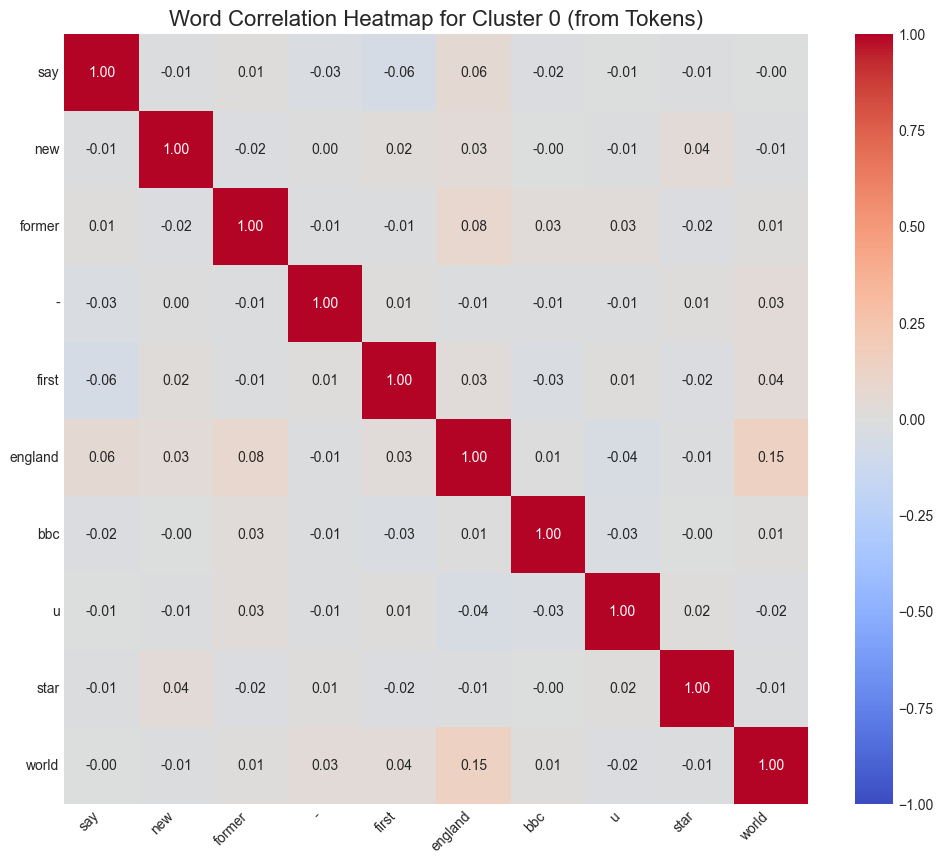

Top 10 Keywords : ['say', '-', 'police', 'people', 'new', 'world', 'woman', 'bbc', 'year', 'england']


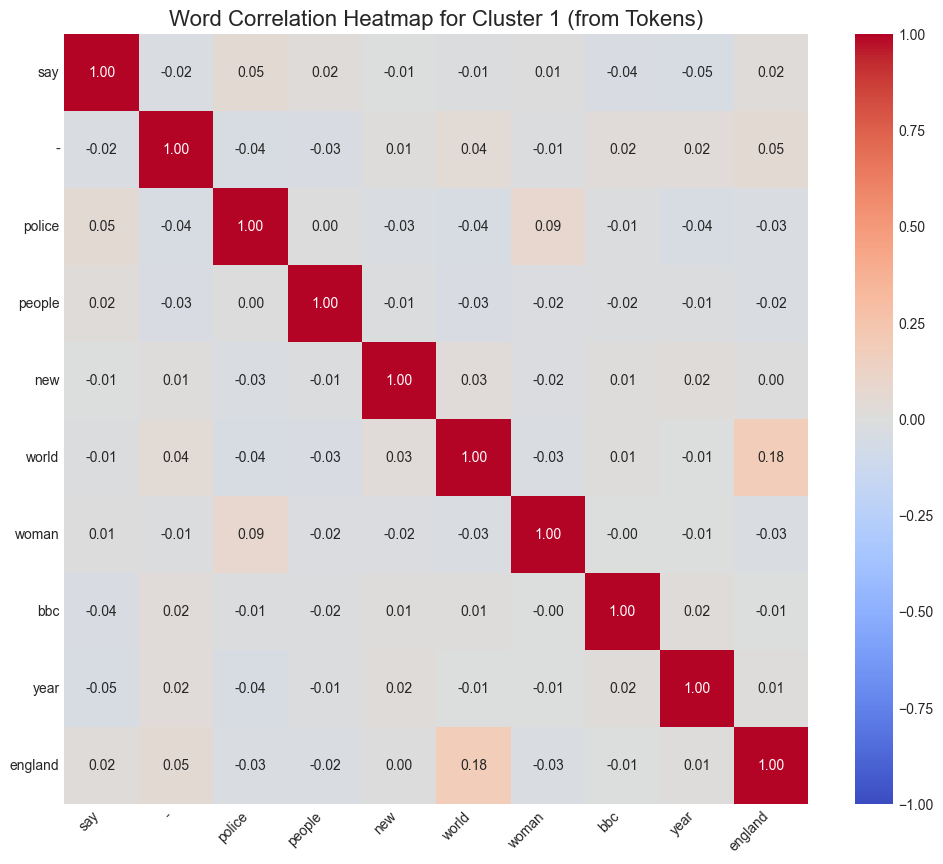

Top 10 Keywords : ['-', 'say', 'u', 'new', 'first', 'people', 'man', 'bbc', 'two', 'one']


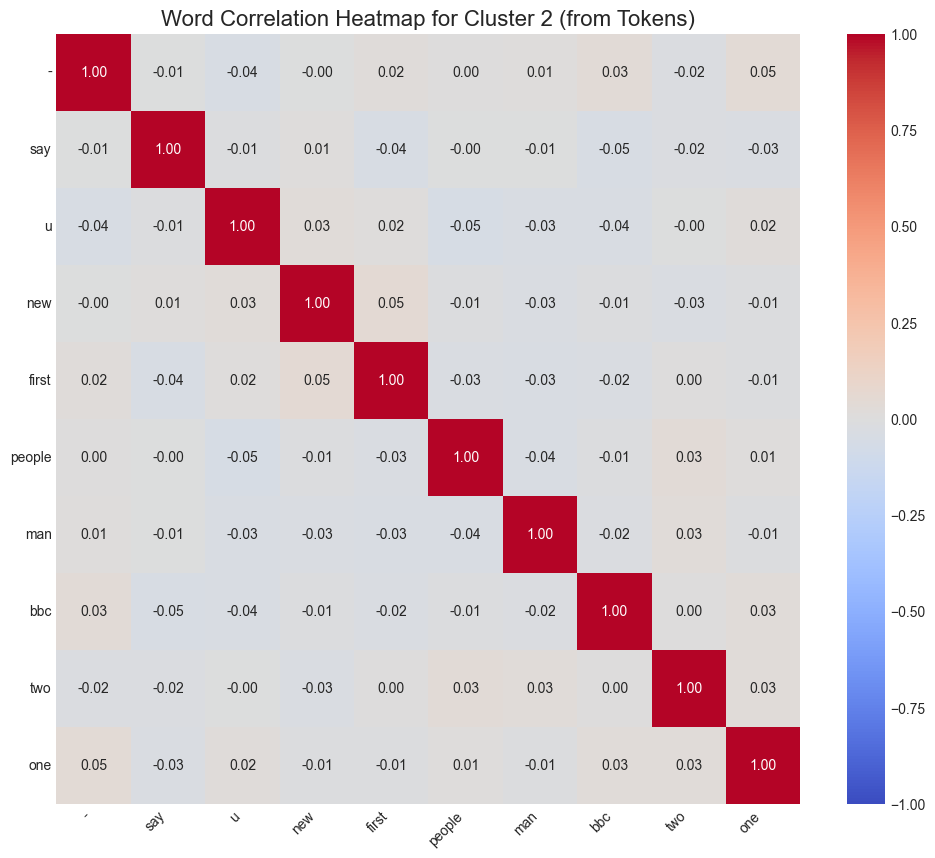

Top 10 Keywords : ['say', 'papers:', 'cost', 'uk', 'energy', 'rate', 'new', 'election', 'labour', 'price']


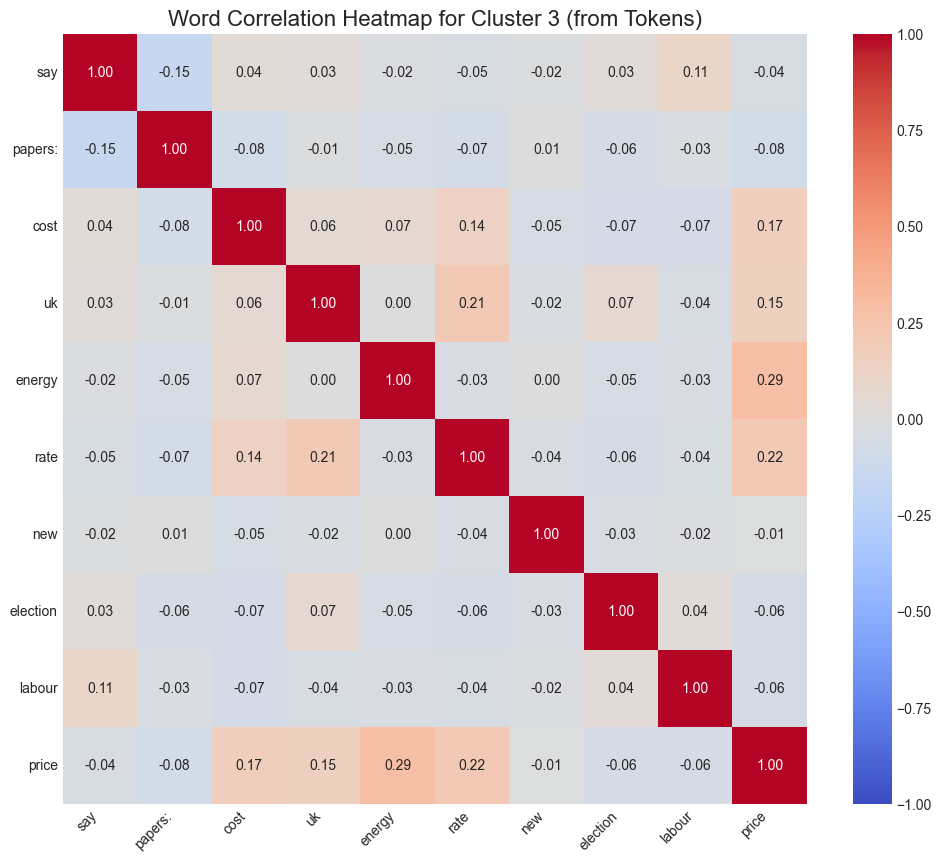

In [34]:
for i in range(0,4):
    create_correlation_heatmap_from_tokens(df_new, cluster_to_analyze=i)

# สร้าง Scatter Plot จากผลลัพธ์ของ t-SNE

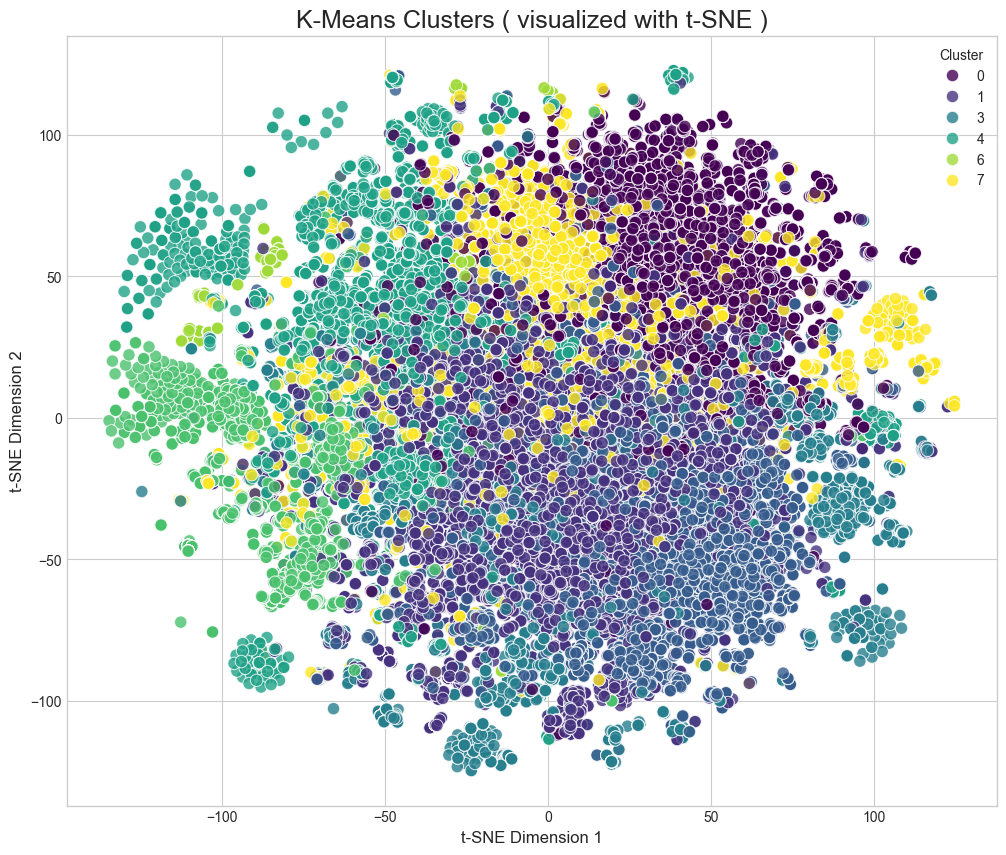

In [35]:
# กำหนดขนาดของกราฟให้เหมาะสมสำหรับกราฟเดี่ยว
plt.figure(figsize=(12, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# ใช้ seaborn ในการวาด Scatter plot
sns.scatterplot(
    data=df_new,
    x='tsne_x',
    y='tsne_y',
    hue='cluster',      # แยกสีตามคอลัมน์ 'cluster'
    palette='viridis',  # เลือกชุดสี
    s=80,               # ขนาดของจุด
    alpha=0.8           # ความโปร่งใส
)

# ตั้งชื่อแกนและหัวข้อของกราฟ
plt.title('K-Means Clusters ( visualized with t-SNE )', fontsize=18)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Cluster') # แสดงคำอธิบายสี

# แสดงกราฟ
plt.show()

# สร้าง Word Cloud ของแต่ละ Cluster

In [36]:
def create_wordcloud_for_cluster(df, cluster_to_analyze):
    """
    ฟังก์ชันสำหรับสร้างและแสดง Word Cloud จากคอลัมน์ 'text'
    สำหรับ Cluster ที่กำหนด
    """
    print(f"กำลังสร้าง Word Cloud สำหรับ Cluster {cluster_to_analyze}...")
    
    # --- กรองข้อมูลเฉพาะ Cluster ที่สนใจ ---
    cluster_df = df[df['cluster'] == cluster_to_analyze]

    if cluster_df.empty:
        print(f"ไม่พบข้อมูลสำหรับ Cluster {cluster_to_analyze}")
        return

    # --- รวม token ทั้งหมดใน cluster และกรอง stopwords ---
    all_tokens = [token for sublist in cluster_df['text'] for token in sublist]
    print(all_tokens[:20])
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in all_tokens if word not in stop_words and word.isalpha()]

    # *** นำ token ที่กรองแล้วมาต่อกันเป็น String เดียว คั่นด้วย space ***
    # นี่คือรูปแบบข้อมูลที่ไลบรารี wordcloud ต้องการ
    text_for_wordcloud = ' '.join(filtered_tokens)
    
    if not text_for_wordcloud:
        print(f"ไม่พบคำสำหรับสร้าง Word Cloud ใน Cluster {cluster_to_analyze} หลังกรอง Stopwords")
        return

    # --- สร้าง object WordCloud พร้อมปรับแต่งค่าต่างๆ ---
    wordcloud = WordCloud(
        width=800,                  # ความกว้างของภาพ
        height=600,                 # ความสูงของภาพ
        background_color='white',   # สีพื้นหลัง
        colormap='viridis',         # ชุดสีของตัวอักษร (ควรใช้ชุดเดียวกับ Heatmap เพื่อความสวยงาม)
        max_words=150,              # จำนวนคำสูงสุดที่จะแสดง
        random_state=42             # ทำให้ผลลัพธ์เหมือนเดิมทุกครั้งที่รัน
    ).generate(text_for_wordcloud) # สร้าง Word Cloud จากข้อความ

    # --- แสดงผลภาพ Word Cloud ---
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") # ปิดการแสดงแกน X, Y
    plt.title(f'Word Cloud for Cluster {cluster_to_analyze}', fontsize=16)
    plt.show()

กำลังสร้าง Word Cloud สำหรับ Cluster 0...
['shane', 'warne:', 'australian', 'cricket', 'legend', 'died', 'natural', 'cause', '-', 'police', 'thai', 'police', 'say', "there's", 'sign', 'foul', 'play', "cricketer's", 'death', 'holiday']


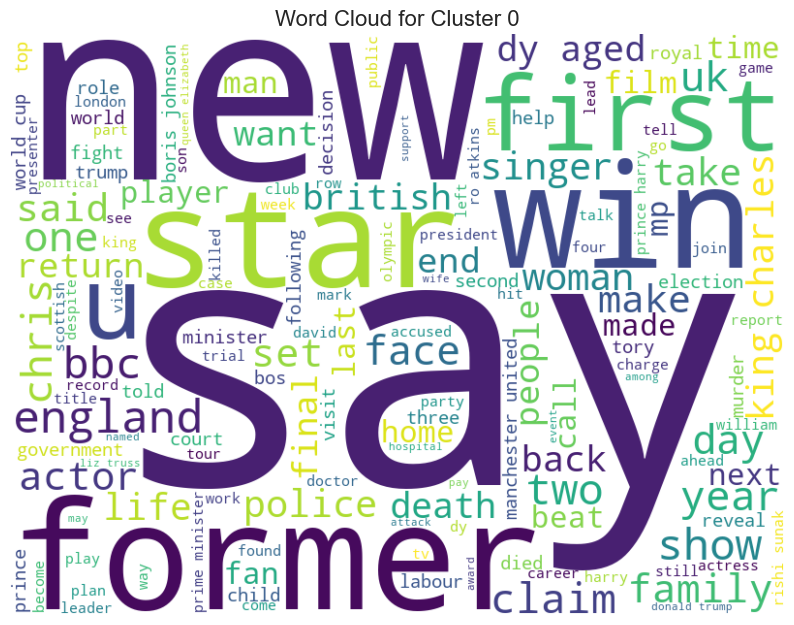

กำลังสร้าง Word Cloud สำหรับ Cluster 1...
['covid:', 'fourth', 'jab', "scotland's", 'vulnerable,', 'testing', 'wind', 'fear', 'wale', 'five', 'thing', 'need', 'know', 'coronavirus', 'pandemic', 'monday', 'morning.', 'protest', 'across', 'russia']


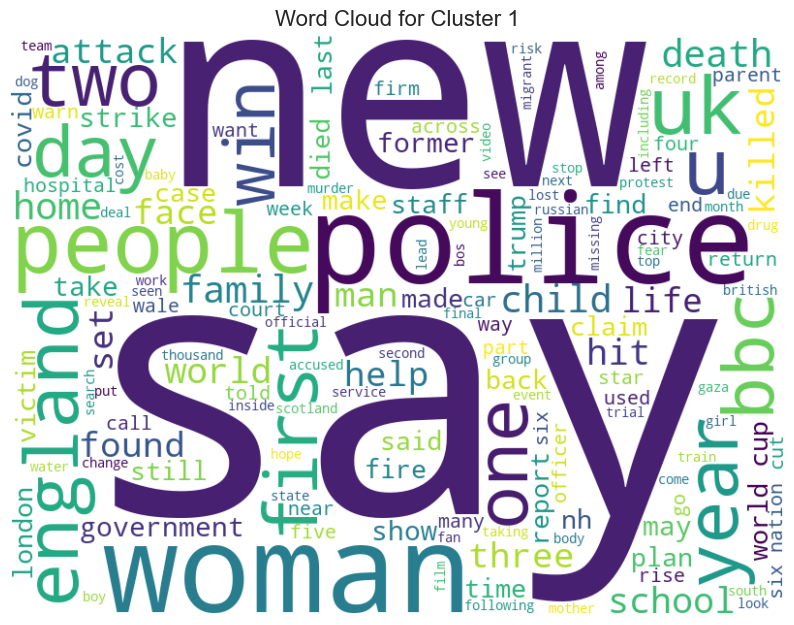

กำลังสร้าง Word Cloud สำหรับ Cluster 2...
['five', 'way', 'ukraine', 'war', 'could', 'push', 'price', 'price', 'everyday', 'item', 'could', 'go', 'time', 'cost', 'living', 'already', 'rising.', "'they", 'thought', 'young']


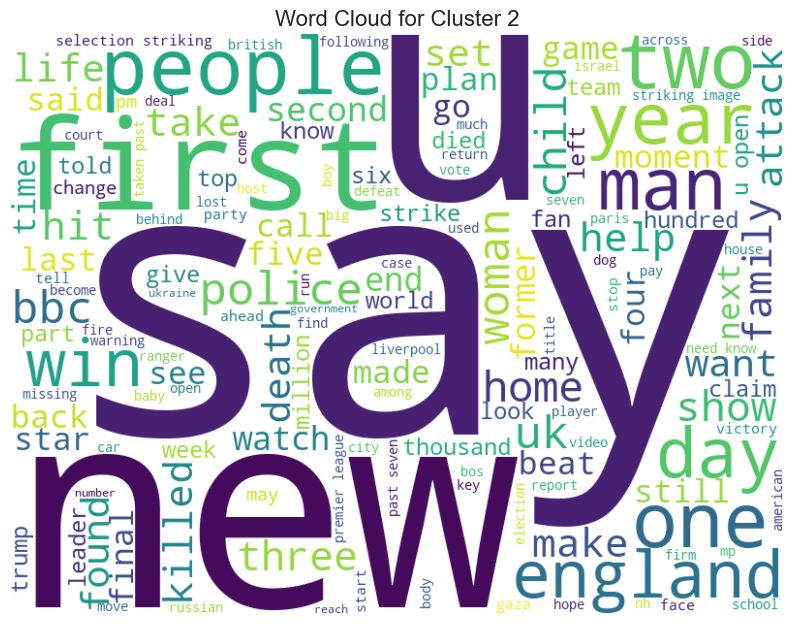

กำลังสร้าง Word Cloud สำหรับ Cluster 3...
['papers:', "'running", "lives'", 'terror', "'rains", "down'", 'civilian', 'attempt', 'flee', 'ukrainian', 'city', 'targeted', 'russian', 'force', 'lead', "monday's", 'papers.', 'economic', 'crime', 'bill:']


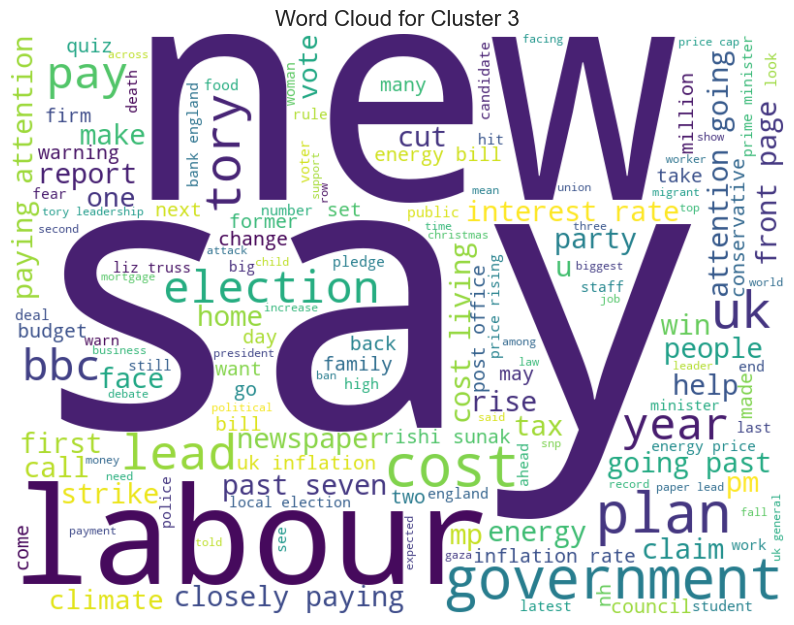

In [37]:
for i in range(0,4):
    create_wordcloud_for_cluster(df_new, cluster_to_analyze=i)

# สรุปผล

## Cluster 0 : ข่าวบันเทิง บุคคลมีชื่อเสียง และราชวงศ์ (Celebrity & Entertainment News)

    ลักษณะเด่น: Cluster นี้เต็มไปด้วยคำที่เกี่ยวข้องกับบุคคลสาธารณะ ดารา นักแสดง และราชวงศ์อย่างชัดเจน คำที่โดดเด่นคือ star, actor, singer, film, bbc, world cup นอกจากนี้ยังมีการปรากฏชื่อบุคคลที่มีชื่อเสียงจำนวนมาก เช่น King Charles, Prince Harry, Boris Johnson, Rishi Sunak, Trump ซึ่งบ่งชี้ว่าเป็นข่าวเกี่ยวกับชีวิตหรือกิจกรรมของบุคคลเหล่านี้มากกว่าเรื่องนโยบาย
    คำสำคัญ: new, say, star, former, win, british, man, woman, film, actor, king, charles, prince harry, bbc, england, government, police, death
    ประเภท: ข่าวบันเทิงและสังคม (Entertainment & Celebrity News)

## Cluster 1: ข่าวอาชญากรรมและอุบัติเหตุ (Crime & Incidents)

    ลักษณะเด่น: คำใน Cluster นี้มีความเชื่อมโยงกับเหตุการณ์เฉพาะหน้า อาชญากรรม และอุบัติเหตุอย่างสูง คำว่า police (ตำรวจ) มีขนาดใหญ่และเด่นชัด ควบคู่ไปกับคำอื่นๆ เช่น attack, killed, death, fire, victim, found, case ซึ่งมักใช้ในการรายงานข่าวอาชญากรรมหรือเหตุฉุกเฉินต่างๆ
    คำสำคัญ: new, say, police, woman, man, people, attack, killed, death, found, report, fire, victim, case, hospital
    ประเภท: ข่าวอาชญากรรมและอุบัติเหตุ (Crime & Accidents)

## Cluster 2: ข่าวทั่วไปและข่าวต่างประเทศ (General & International News)

    ลักษณะเด่น: Cluster นี้มีลักษณะเป็นข่าวทั่วไปที่ครอบคลุมหลากหลายประเด็น มีทั้งคำที่เกี่ยวกับเหตุการณ์ในประเทศและต่างประเทศที่สำคัญ เช่น strike (การประท้วงหยุดงาน), gaza (กาซา), ukraine (ยูเครน), russian (รัสเซีย) ซึ่งบ่งชี้ถึงการรายงานข่าวความขัดแย้งและสถานการณ์ระหว่างประเทศ นอกจากนี้ยังมีคำทั่วไปที่พบในหัวข้อข่าวหลากหลายประเภท
    คำสำคัญ: new, say, people, year, world, police, attack, strike, killed, death, gaza, ukraine, russian, trump
    ประเภท: ข่าวทั่วไปและสถานการณ์ต่างประเทศ (General & World News)

## Cluster 3: ข่าวการเมืองและเศรษฐกิจ (Politics & Economics)

    ลักษณะเด่น: Cluster นี้มีความเฉพาะเจาะจงสูงมากในด้านการเมืองและเศรษฐกิจของสหราชอาณาจักร คำที่โดดเด่นที่สุดคือ labour (พรรคแรงงาน), tory (พรรคอนุรักษนิยม), government (รัฐบาล) และคำศัพท์ทางเศรษฐกิจ เช่น cost (ค่าครองชีพ), energy bill (ค่าพลังงาน), inflation (เงินเฟ้อ), interest rate (อัตราดอกเบี้ย), tax (ภาษี), budget (งบประมาณ) ชี้ให้เห็นว่าเนื้อหาหลักเกี่ยวข้องกับนโยบาย การเลือกตั้ง และสภาพเศรษฐกิจ
    คำสำคัญ: new, say, labour, tory, government, cost, energy, bill, inflation, interest rate, pay, tax, election, conservative, pm, sunak
    ประเภท: ข่าวการเมืองและเศรษฐกิจ (Politics & Economics)